In [1]:
import pickle
import argparse
import time

import numpy as np

In [2]:
with open('output/filtered_model.bin', 'rb') as inp:
    model = pickle.load(inp)

In [3]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier

from localization import utils, dataset

In [4]:

def filter_matrix_by_row(y, target_y):
    """
    :param y: matrix N x O
    :param target_y: vector 1 x O
    :return: indexes where y matches target_y
    """
    match = (y == target_y)
    row_equal = np.all(match, axis=1)
    indexes = np.where(row_equal)
    return indexes


def evaluate_model(continuous_location_model, discrete_model, dataset, y_real):
    start_time = time.time()
    # _, X_test = dataset.get_X()
    X_test, _ = dataset.get_X()
    predicted_discrete_location = discrete_model.predict(X_test)
    predicted_continuous_location = np.zeros((X_test.shape[0], 4))

    # _, X_test = dataset.get_X_df()
    X_test, _ = dataset.get_X_df()
    locations, counts = np.unique(predicted_discrete_location, axis=0, return_counts=True)
    # for each discrete location, apply the respective model
    for location in locations:
        indexes = filter_matrix_by_row(predicted_discrete_location, location)
        x_test_in_loc = X_test.iloc[indexes]
        y_pred, dist = continuous_location_model.pred(x_test_in_loc, selected_building=location[0],
                                                      selected_floor=location[1])
        predicted_continuous_location[indexes, :] = y_pred

    y_pred = np.vstack([predicted_continuous_location[:, 2], predicted_continuous_location[:, 3]]).T
    end_time = time.time()
    distances = np.linalg.norm(y_pred - y_real, axis=1)
    elapsed_seconds = (end_time - start_time)
    return distances, elapsed_seconds


def train_discrete_location_model(x_train, y, metric, k):
    neigh = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
    classifier = MultiOutputClassifier(neigh, n_jobs=-1)
    classifier.fit(x_train, y)
    return classifier


def evaluate_categorical_location_model(model, x_test, y_test):
    start_time = time.time()
    y_hat = model.predict(x_test)
    end_time = time.time()

    correct_indexes = np.argwhere(((y_hat == y_test).sum(axis=1) == 2)).flatten()
    score = correct_indexes.shape[0] / y_hat.shape[0]

    elapsed_seconds = (end_time - start_time)
    return score, correct_indexes, elapsed_seconds

def error_plot(data):
    import matplotlib.pyplot as plt
    # try:
    #     import scienceplots
    #     plt.style.use(['science','ieee'])
    # except:
    #     print("SciencePlots not found")

    scores = data
    threshold = np.percentile(data, 90)

    plt.figure()
    plt.scatter(range(len(scores)),scores,c=~np.array([scores <= threshold]),cmap="bwr", s=2)
    plt.plot(range(len(scores)), threshold*np.ones(len(scores)),'g',linewidth=2)
    plt.title("Model outliers")
    plt.xlabel('Index')
    plt.ylabel('Absolute Error')
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
dataset = dataset.load_ujiindoor_loc(data_folder='data/filtered')

In [8]:
model

In [9]:
model.sigma

6.75

In [10]:
building_map = model.construct_building_map(dataset, 1)

In [11]:
building_map[0]


array([-15.59638683, -13.78350651, -17.40926714, ...,   7.97105727,
         9.78393758,   9.78393758])

In [12]:
import matplotlib.pyplot as plt


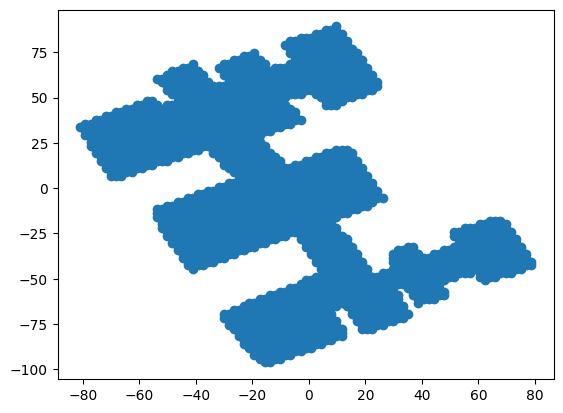

In [13]:
plt.scatter(building_map[0], building_map[1])

In [14]:
model.num_buildings

3

In [15]:
model.num_floors_in_each_building

{0: 4, 1: 4, 2: 5}

In [16]:
model.get_valid_routers_building_and_floor(0, 0)

['WAP007',
 'WAP013',
 'WAP014',
 'WAP023',
 'WAP024',
 'WAP025',
 'WAP026',
 'WAP027',
 'WAP028',
 'WAP029',
 'WAP030',
 'WAP033',
 'WAP034',
 'WAP035',
 'WAP036',
 'WAP039',
 'WAP040',
 'WAP041',
 'WAP042',
 'WAP051',
 'WAP052',
 'WAP053',
 'WAP054',
 'WAP057',
 'WAP058',
 'WAP071',
 'WAP072',
 'WAP075',
 'WAP076',
 'WAP080',
 'WAP081',
 'WAP155',
 'WAP156',
 'WAP161',
 'WAP162',
 'WAP224',
 'WAP225',
 'WAP253',
 'WAP268',
 'WAP323',
 'WAP434',
 'WAP452']

In [17]:
model.power_probability_masks[0][0]['WAP007']

{0: array([0.00054408, 0.00054534, 0.00054383, ..., 0.00072643, 0.00072712,
        0.00072781]),
 1: array([2.05651033e-06, 2.09267702e-06, 1.73150209e-06, ...,
        1.28794751e-03, 1.28915552e-03, 1.29035797e-03]),
 2: array([ 0.00086583,  0.00088141,  0.00072685, ..., -0.00056575,
        -0.00063001, -0.0006947 ]),
 3: array([ 0.00088874,  0.00090505,  0.0007441 , ..., -0.00054417,
        -0.00060083, -0.00065666]),
 4: array([ 0.00091956,  0.0009367 ,  0.00076815, ..., -0.00051277,
        -0.00055959, -0.00060453]),
 5: array([ 0.00095914,  0.00097721,  0.0007998 , ..., -0.00046979,
        -0.00050549, -0.00053876]),
 6: array([ 0.00100794,  0.00102702,  0.00083957, ..., -0.00041615,
        -0.00044101, -0.0004635 ]),
 7: array([ 0.00106591,  0.00108604,  0.00088763, ..., -0.00035574,
        -0.00037151, -0.00038546]),
 8: array([ 0.00113227,  0.00115341,  0.00094366, ..., -0.00029415,
        -0.00030338, -0.00031145]),
 9: array([ 0.00120534,  0.00122733,  0.00100669, ..

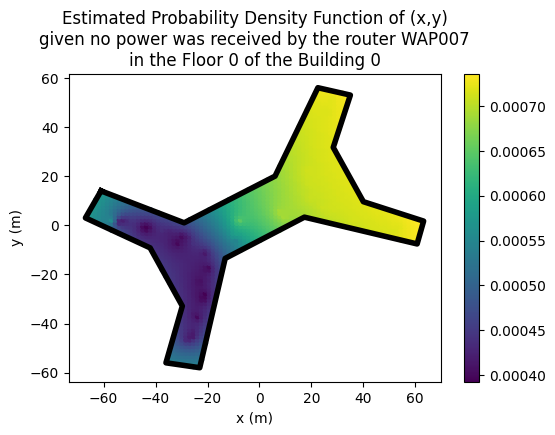

In [18]:
model.plot_density_function_xy_given_bfrp(0, 0, 'WAP007', 100)

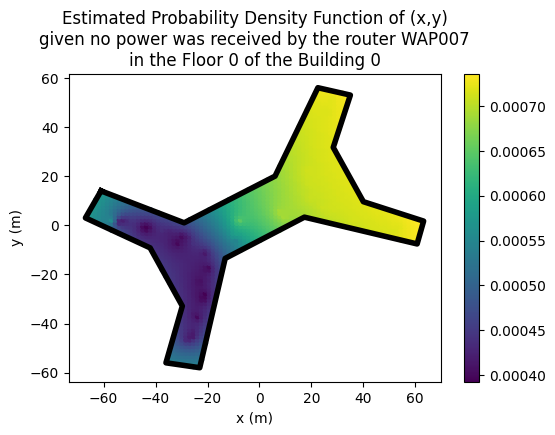

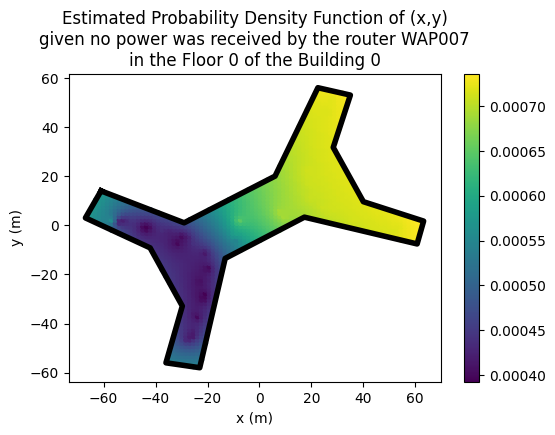

KeyError: 210

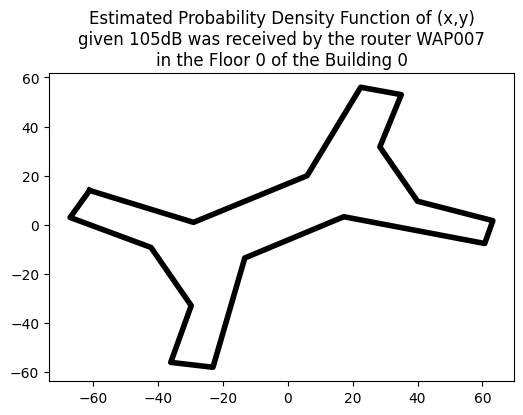

In [19]:
model.plot_density_function_xy_given_bfr_for_different_p(0, 0, 'WAP007', [0, 100, 105])

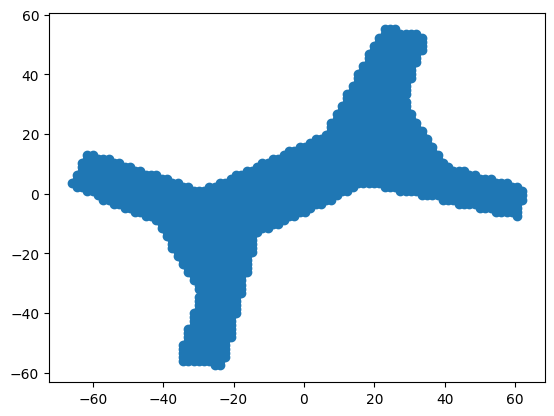

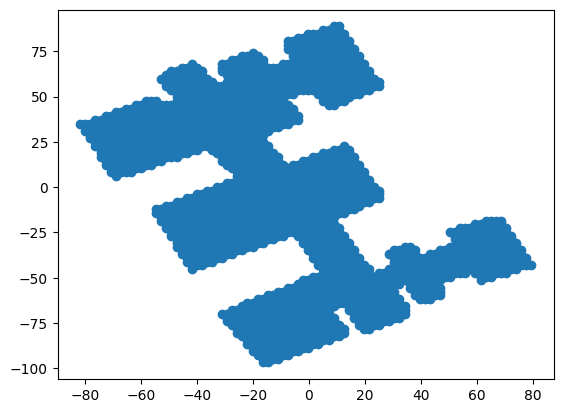

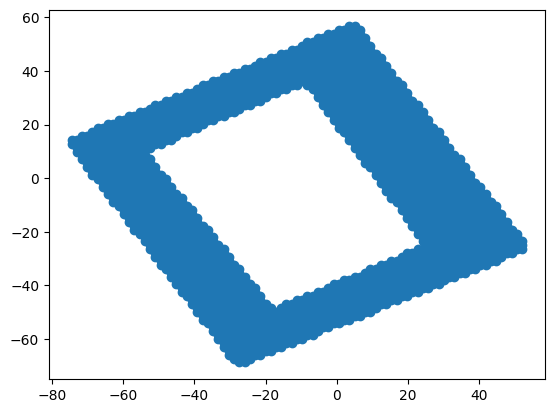

In [ ]:
for i in range(3):
    
    plt.scatter(model.x_building[i], model.y_building[i])
    plt.show()

In [ ]:
max = 0
maxi = 0
soma = 0
for i in range(105):
    soma += model.power_probability_masks[0][0]['WAP013'][i][0]
    if (model.power_probability_masks[0][0]['WAP013'][i][0] > max):
        max = model.power_probability_masks[0][0]['WAP013'][i][0]
        maxi = i
        

In [ ]:
model.power_probability_masks[0][0]['WAP007'][0].sum()

1.0

In [ ]:
soma

0.2836258872877158

In [ ]:
max

0.0015926439792907532

In [ ]:
maxi

16

In [ ]:
model.x_building[0]

array([-25.32809398, -23.82141014, -34.36819701, ...,  22.88578885,
        24.39247269,  25.89915652])

In [ ]:
arr = np.array([model.power_probability_masks[0][0]['WAP013'][i].sum() for i in range(0,106)])

In [ ]:
np.isclose(arr, 1.00).sum()

106

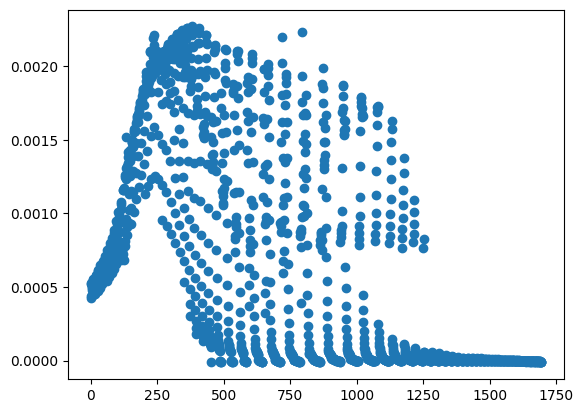

In [ ]:
plt.scatter(range(1695), model.power_probability_masks[0][0]['WAP007'][30])

In [33]:
model.power_prior_probability_distribution[0][0]['WAP007']

{0: 0.7609860664523044,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0010718113612004287,
 9: 0.0010718113612004287,
 10: 0.003215434083601286,
 11: 0.0053590568060021436,
 12: 0.003215434083601286,
 13: 0.0010718113612004287,
 14: 0.0,
 15: 0.0,
 16: 0.0053590568060021436,
 17: 0.011789924973204717,
 18: 0.011789924973204717,
 19: 0.006430868167202572,
 20: 0.006430868167202572,
 21: 0.00964630225080386,
 22: 0.004287245444801715,
 23: 0.007502679528403001,
 24: 0.00964630225080386,
 25: 0.00857449088960343,
 26: 0.011789924973204717,
 27: 0.0010718113612004287,
 28: 0.003215434083601286,
 29: 0.00857449088960343,
 30: 0.011789924973204717,
 31: 0.00857449088960343,
 32: 0.004287245444801715,
 33: 0.003215434083601286,
 34: 0.0021436227224008574,
 35: 0.0021436227224008574,
 36: 0.004287245444801715,
 37: 0.006430868167202572,
 38: 0.00857449088960343,
 39: 0.004287245444801715,
 40: 0.00857449088960343,
 41: 0.0010718113612004287,
 42: 0.003215434083601286,
 4

In [34]:
model.power_probability_masks[0][0]['WAP007']

{0: array([0.00054408, 0.00054534, 0.00054383, ..., 0.00072643, 0.00072712,
        0.00072781]),
 1: array([2.05651033e-06, 2.09267702e-06, 1.73150209e-06, ...,
        1.28794751e-03, 1.28915552e-03, 1.29035797e-03]),
 2: array([ 0.00086583,  0.00088141,  0.00072685, ..., -0.00056575,
        -0.00063001, -0.0006947 ]),
 3: array([ 0.00088874,  0.00090505,  0.0007441 , ..., -0.00054417,
        -0.00060083, -0.00065666]),
 4: array([ 0.00091956,  0.0009367 ,  0.00076815, ..., -0.00051277,
        -0.00055959, -0.00060453]),
 5: array([ 0.00095914,  0.00097721,  0.0007998 , ..., -0.00046979,
        -0.00050549, -0.00053876]),
 6: array([ 0.00100794,  0.00102702,  0.00083957, ..., -0.00041615,
        -0.00044101, -0.0004635 ]),
 7: array([ 0.00106591,  0.00108604,  0.00088763, ..., -0.00035574,
        -0.00037151, -0.00038546]),
 8: array([ 0.00113227,  0.00115341,  0.00094366, ..., -0.00029415,
        -0.00030338, -0.00031145]),
 9: array([ 0.00120534,  0.00122733,  0.00100669, ..

In [101]:
power_probs = model.power_probability_masks[0][0]['WAP071']
powers = list(power_probs.keys())
probs = [power_probs[p][0] for p in powers]

In [102]:
probs

[0.0007186254658188865,
 0.0011129081787280017,
 -0.001370080978669206,
 -0.0012572581127010575,
 -0.0011243976114871186,
 -0.0009788678932278344,
 -0.0008309856554260134,
 -0.0006908491259908887,
 -0.000565685307031267,
 -0.000458934148387973,
 -0.00037087019900577007,
 -0.0002998295652544338,
 -0.0002433100116271416,
 -0.00019868575959468228,
 -0.0001635716626331567,
 -0.00013595721204427678,
 -0.00011421748048020686,
 -9.707062606707139e-05,
 -8.351958964023196e-05,
 -7.279529696630423e-05,
 -6.430778414013987e-05,
 -5.760655038621337e-05,
 -5.234937673441665e-05,
 -4.8278230624941935e-05,
 -4.520087453240894e-05,
 -4.2977009646836077e-05,
 -4.1508032940817354e-05,
 -4.0729698486212685e-05,
 -4.060713754211521e-05,
 -4.11318158482929e-05,
 -4.232010429067253e-05,
 -4.421321929813413e-05,
 -4.6878353541997545e-05,
 -5.041086203478115e-05,
 -5.493738726241297e-05,
 -6.061979247609539e-05,
 -6.765971795554934e-05,
 -7.630347530825813e-05,
 -8.684684668006024e-05,
 -9.963916128931338e-0

In [92]:
min(probs)

-0.003347123816783325

In [103]:
probs = np.clip(probs, 0, None)
epsilon = 1e-5
probs = probs + epsilon

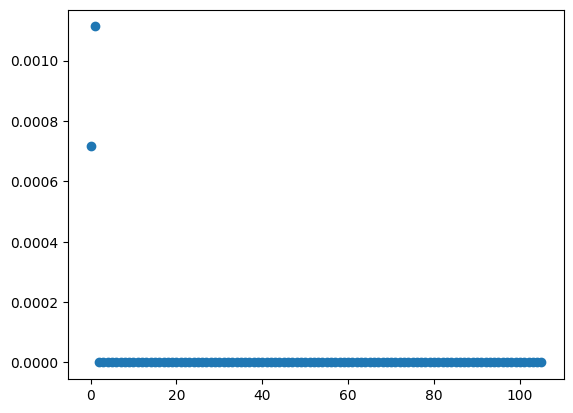

In [93]:
plt.scatter(powers, np.clip(probs, 0, None))

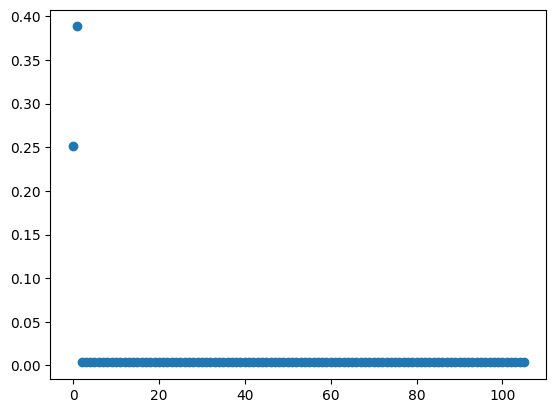

In [105]:
plt.scatter(powers, probs)

In [106]:
probs

array([0.25198582, 0.38834346, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345837,
       0.00345837, 0.00345837, 0.00345837, 0.00345837, 0.00345

In [104]:
probs = np.array(probs) / np.sum(probs)

In [63]:
np.random.choice(powers, p=probs)

76

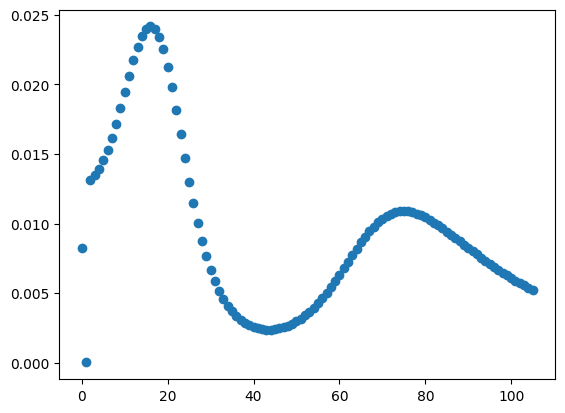

In [62]:
plt.scatter(powers, probs)

In [64]:
np.sum(probs)

0.9999999999999999

In [35]:
from tqdm import tqdm

In [38]:
list(model.power_probability_masks.keys())

[0, 1, 2]

In [40]:
for floor in model.power_probability_masks[0].keys():
    print(floor)

0
1
2
3


In [ ]:
4*100*

In [41]:
np.arange(len(model.x_building[0]))

array([   0,    1,    2, ..., 1692, 1693, 1694])

In [36]:
for building in tqdm(model.power_probability_masks.keys(), desc="Processing buildings"):
    print(building)

Processing buildings: 100%|██████████| 3/3 [00:00<?, ?it/s]

0
1
2


In [44]:
model.x_building[0].shape

(1695,)

In [5]:
from localization.augmentation.augmentation_rbf_model import Augmentation

In [109]:
augmenter = Augmentation(model)
augmented_df = augmenter.generate_augmented_data(num_samples_per_floor=10)

ValueError: probabilities are not non-negative

In [113]:
import pandas as pd
df = pd.read_csv('data/filtered/validationData.csv')

In [120]:
df.columns[:-9]

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP511', 'WAP512', 'WAP513', 'WAP514', 'WAP515', 'WAP516', 'WAP517',
       'WAP518', 'WAP519', 'WAP520'],
      dtype='object', length=520)

In [67]:
probs

array([8.25377037e-03, 3.11977493e-05, 1.31348336e-02, 1.34824047e-02,
       1.39499521e-02, 1.45503543e-02, 1.52906646e-02, 1.61700383e-02,
       1.71767992e-02, 1.82853398e-02, 1.94544209e-02, 2.06281491e-02,
       2.17396788e-02, 2.27166545e-02, 2.34872626e-02, 2.39862530e-02,
       2.41607868e-02, 2.39760690e-02, 2.34203646e-02, 2.25083978e-02,
       2.12817526e-02, 1.98051986e-02, 1.81589652e-02, 1.64284230e-02,
       1.46936210e-02, 1.30211106e-02, 1.14595147e-02, 1.00389470e-02,
       8.77331934e-03, 7.66414831e-03, 6.70461308e-03, 5.88306732e-03,
       5.18567006e-03, 4.59813605e-03, 4.10677604e-03, 3.69904191e-03,
       3.36376396e-03, 3.09121394e-03, 2.87307664e-03, 2.70237510e-03,
       2.57337308e-03, 2.48146710e-03, 2.42307544e-03, 2.39552871e-03,
       2.39696483e-03, 2.42622870e-03, 2.48277567e-03, 2.56657606e-03,
       2.67801735e-03, 2.81780031e-03, 2.98682581e-03, 3.18606942e-03,
       3.41644279e-03, 3.67864197e-03, 3.97298571e-03, 4.29924901e-03,
      

In [8]:
import pickle
import argparse
import time

import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier

from localization import utils, dataset

In [6]:
dataset = dataset.load_ujiindoor_loc(data_folder='data/generated2', transform=False)

In [ ]:
df.sample()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,100,100,100,100,100,100,100,100,100,100,...,100,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711
1107,100,100,100,100,100,100,100,100,100,100,...,100,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730
1108,100,100,100,100,100,100,100,100,100,100,...,100,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781
1109,100,100,100,100,100,100,100,100,100,100,...,100,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807


In [5]:
import pickle
import argparse
import time

import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier

from localization import utils, dataset

In [15]:
# dataset_augmented = dataset.load_ujiindoor_loc(data_folder='data/augmented_probs', transform=False)
dataset_augmented = dataset.load_ujiindoor_loc(data_folder='data/generated2', transform=False)

In [16]:
x_train, X_test = dataset_augmented.get_X()

In [17]:
y_train, y_test = dataset_augmented.get_categorical_y()

In [18]:
y_continuous_train, y_continuous_test = dataset_augmented.get_normalized_y()

In [19]:
discrete_location_model = train_discrete_location_model(x_train, y_train, 'euclidean', 3)

In [20]:
score, correct_indexes, elapsed_time = evaluate_categorical_location_model(discrete_location_model, x_train, y_train)

In [21]:
print('Building and floor accuracy:', np.round(100 * score, 2))
print('Prediction time:', np.round(elapsed_time, 2), 's\n')

Building and floor accuracy: 97.41
Prediction time: 3.64 s



In [22]:
distances, elapsed_time = evaluate_model(model, discrete_location_model, dataset_augmented, y_continuous_train)
print(f'Mean error = {np.mean(distances):.2f}, median error = {np.median(distances):.2f}, '
        f'P90 = {np.percentile(distances, 90):.2f}, P95 = {np.percentile(distances, 95):.2f}')
print('Removing the discrete position errors:')

Mean error = 80.70, median error = 84.68, P90 = 118.03, P95 = 124.22
Removing the discrete position errors:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


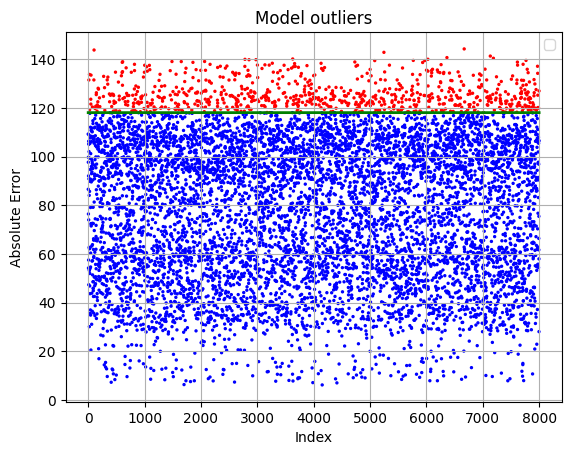

In [23]:
error_plot(distances)

In [30]:
distances = distances[correct_indexes]
print(f'Mean error = {np.mean(distances):.2f}, median error = {np.median(distances):.2f}, '
        f'P90 = {np.percentile(distances, 90):.2f}, P95 = {np.percentile(distances, 95):.2f}')
print('Prediction time:', np.round(elapsed_time, 2), 's')
print('End of execution')

Mean error = 8.20, median error = 6.33, P90 = 15.65, P95 = 21.27
Prediction time: 584.76 s
End of execution


In [195]:
df = pd.read_csv('data/augmented_bayes/validationData.csv')

In [203]:
df['BUILDINGID'].unique()

array([1, 2], dtype=int64)

In [196]:
df.loc[4000:6000, ['BUILDINGID', 'FLOOR']]

,BUILDINGID,FLOOR
4000,2,2
4001,2,2
4002,2,2
4003,2,2
4004,2,2
...,...,...
5996,2,4
5997,2,4
5998,2,4
5999,2,4


In [199]:
for group in df.loc[2000:4000, ['BUILDINGID', 'FLOOR']].groupby('BUILDINGID'):
    print(group[1])

      BUILDINGID  FLOOR
2000           2      0
2001           2      0
2002           2      0
2003           2      0
2004           2      0
...          ...    ...
3996           2      2
3997           2      2
3998           2      2
3999           2      2
4000           2      2

[2001 rows x 2 columns]
